In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; print('Tensorflow version:',tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score

Tensorflow version: 2.8.1


In [2]:
print('Available devices:', tf.config.list_physical_devices())

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(2*1024))]
#     )

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
DIRECTORY = 'dataset'
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 16
COLOR_MODE='grayscale'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE    
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="training"
    , seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      directory=DIRECTORY
    , image_size=IMAGE_SIZE
    , batch_size=BATCH_SIZE
    , color_mode=COLOR_MODE
    , validation_split=0.2
    , subset="validation"
    , seed=123
)

Found 5481 files belonging to 8 classes.
Using 4385 files for training.
Found 5481 files belonging to 8 classes.
Using 1096 files for validation.


In [4]:
qtyLabels = [0]*8
Images = {}
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        label = int(label)
        qtyLabels[label] += 1  
        if ( label in Images ):
            if  ( len(Images[label]) < 20 ):
                Images[label].append(image)
        else:
            Images[label] = []
            Images[label].append(image)
class_names = train_dataset.class_names
print(' '.join( ['{:<12}'.format(el) for el in class_names] ))
print(' '.join( ['{:<12}'.format(el) for el in qtyLabels] ))

anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
711          180          355          440          1105         396          588          610         


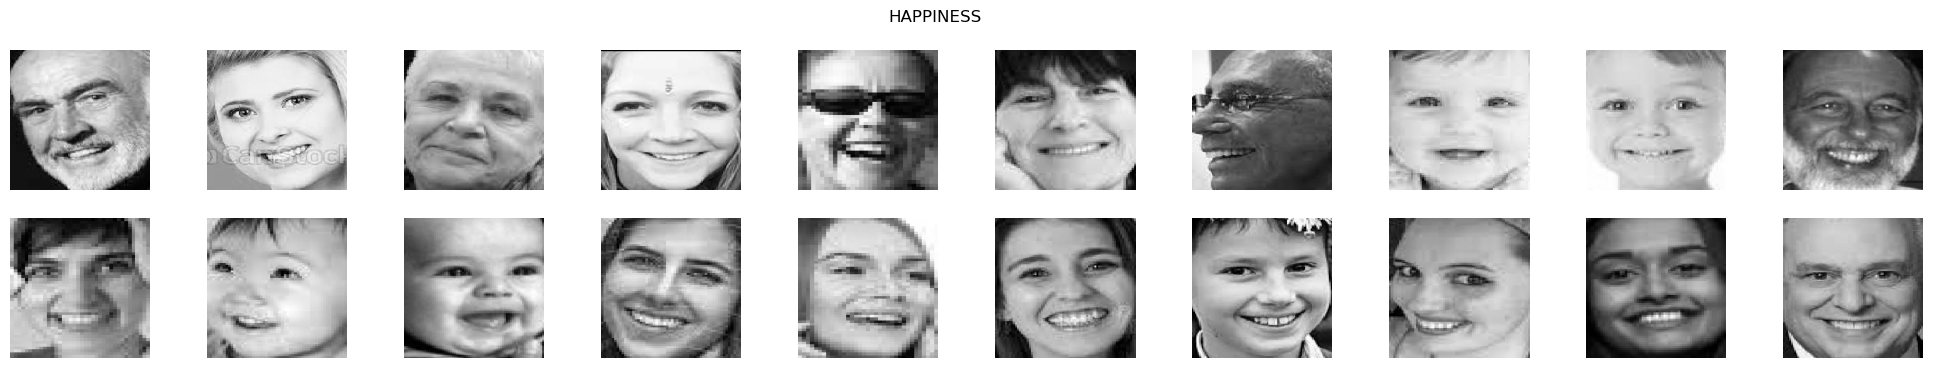

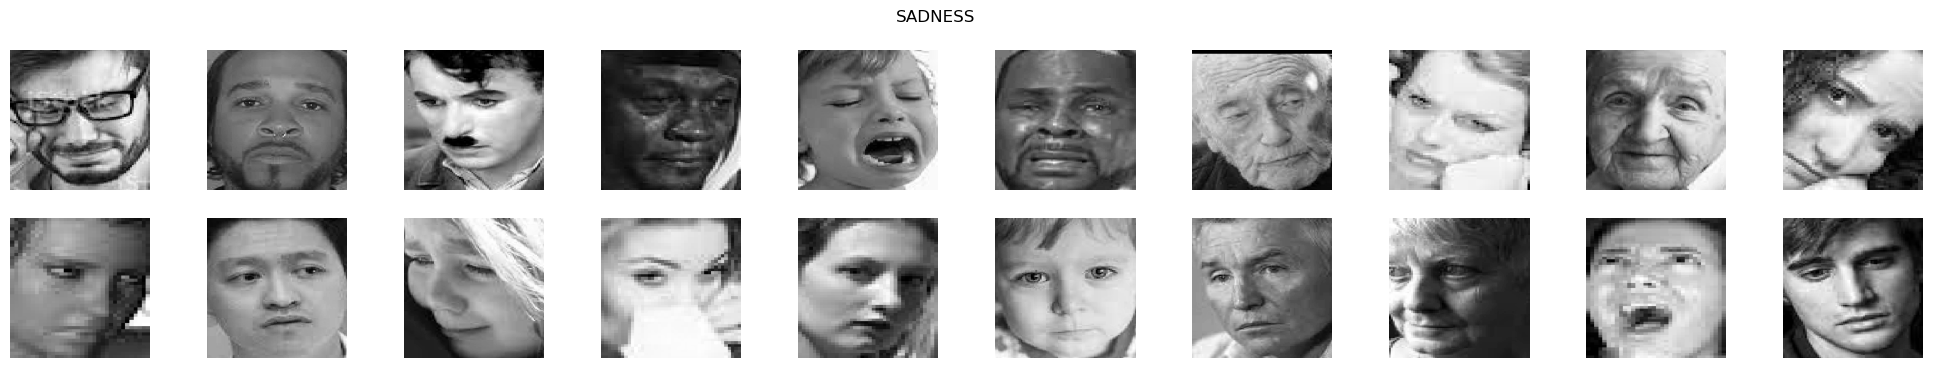

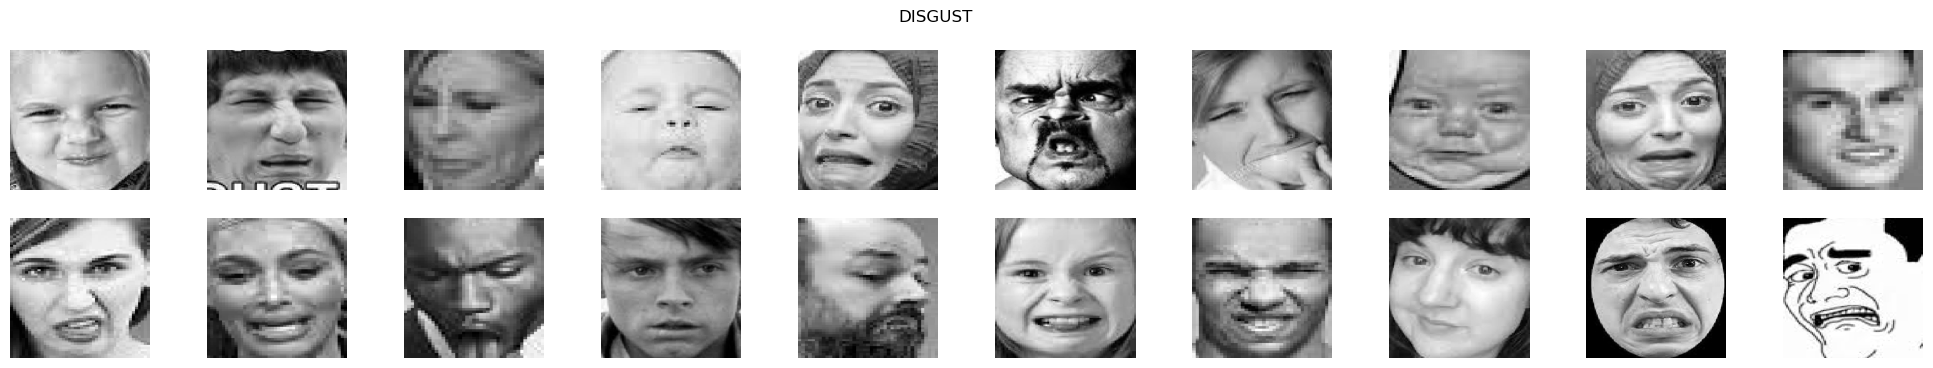

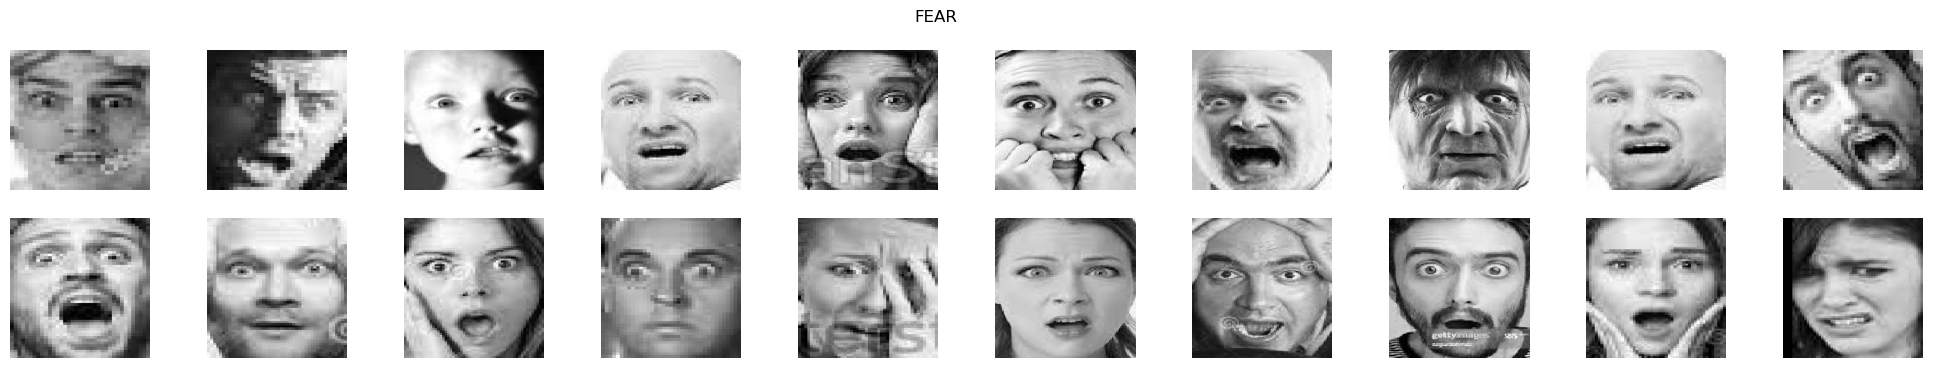

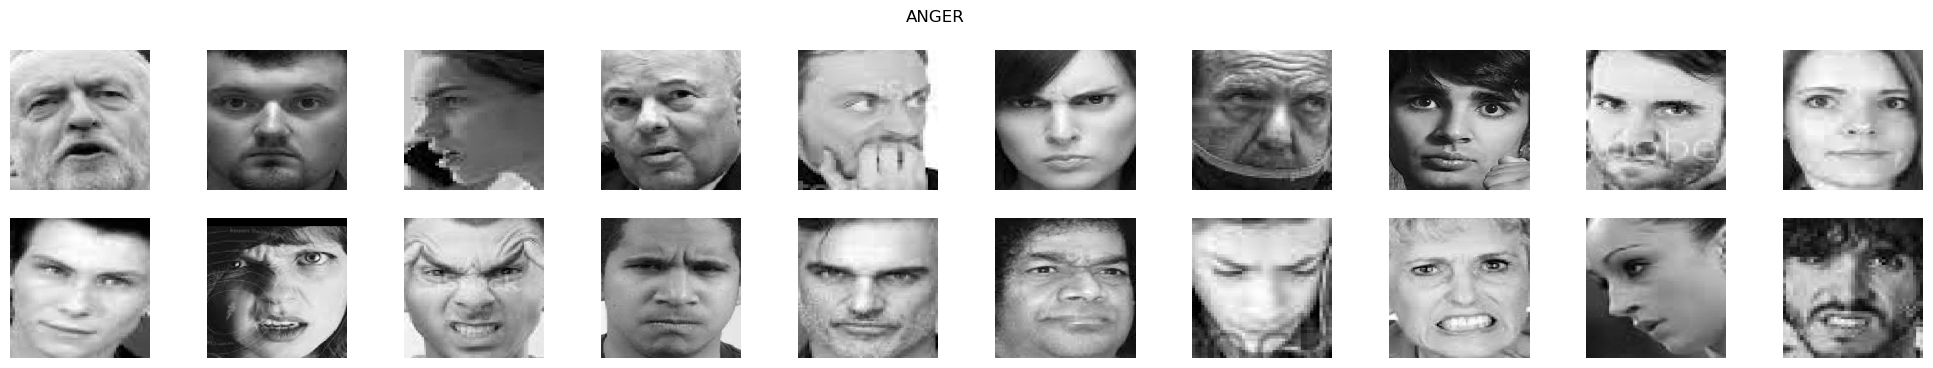

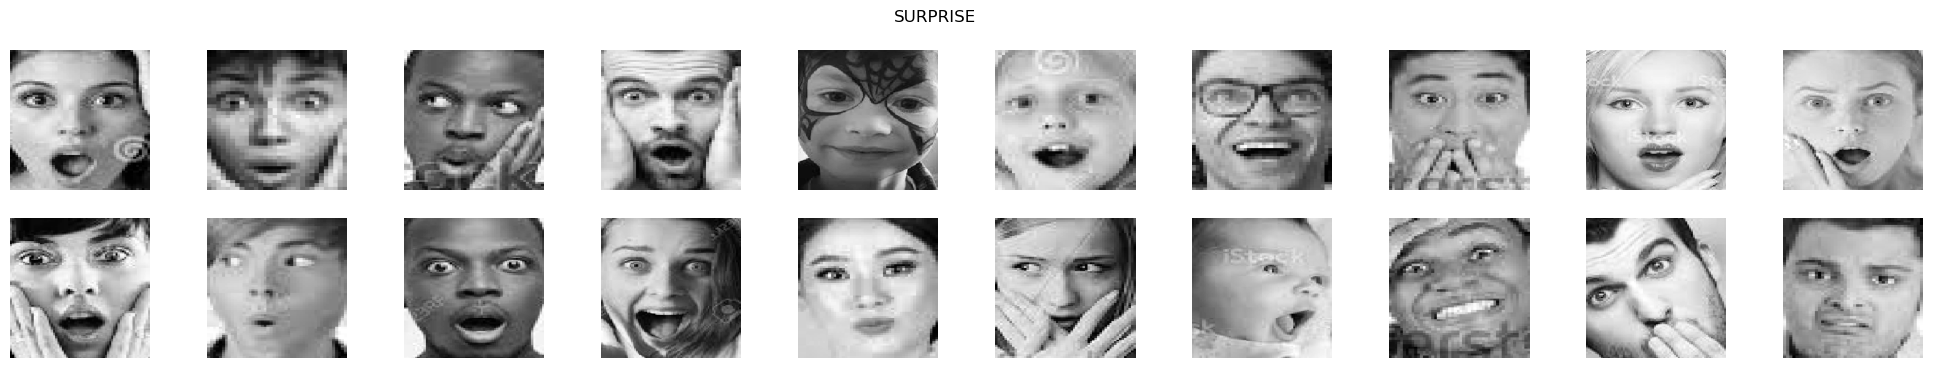

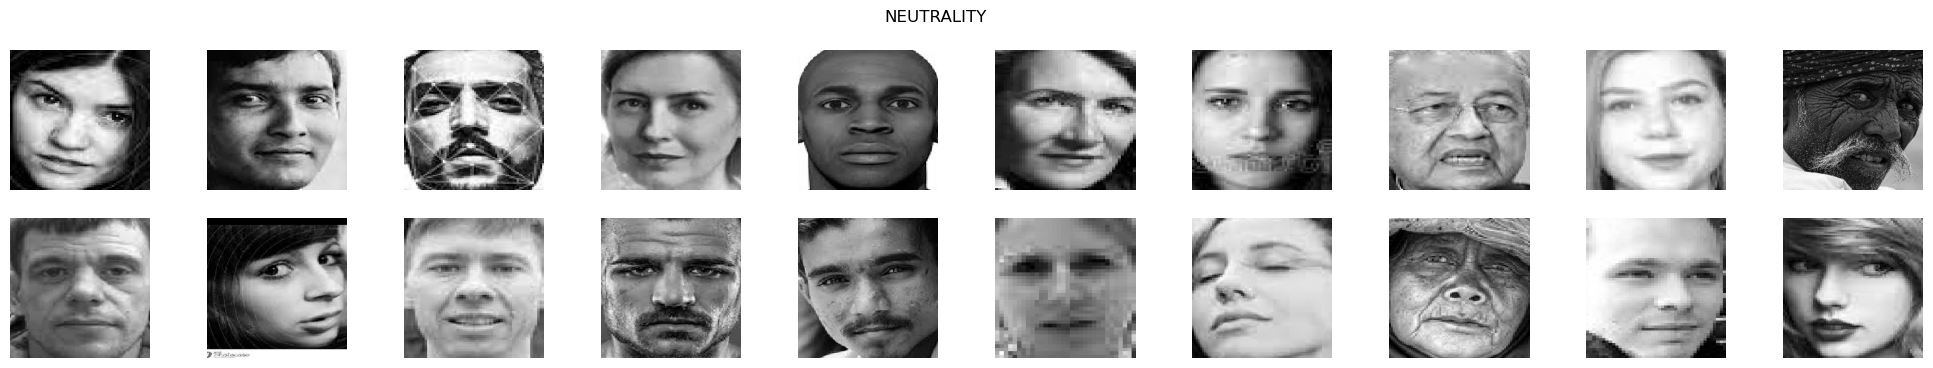

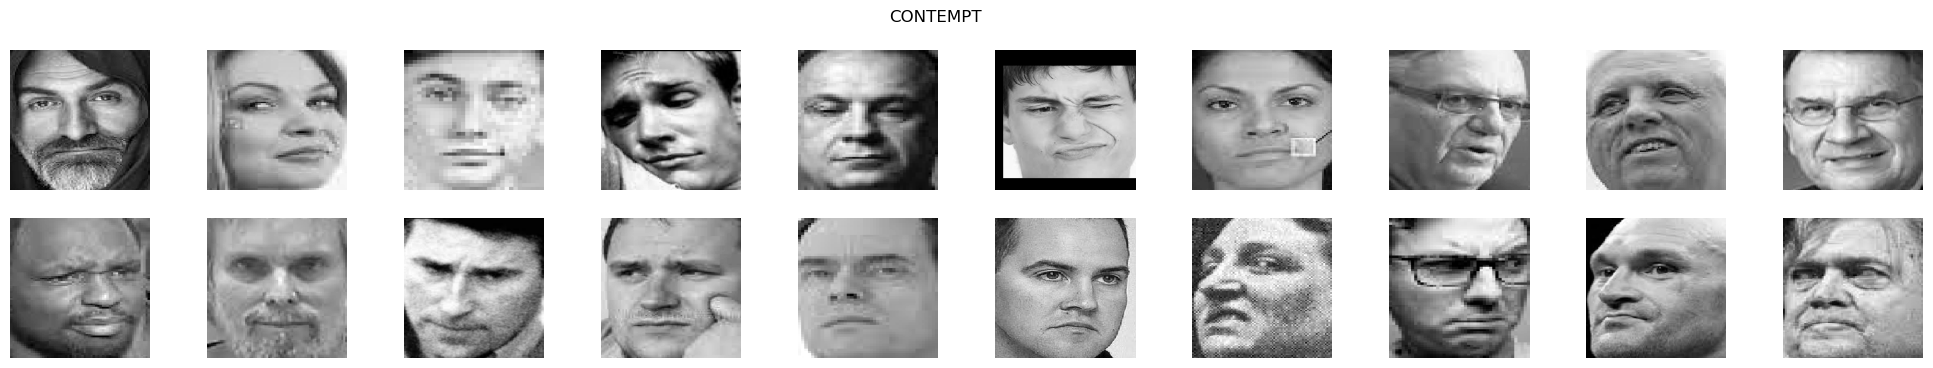

In [5]:
for label in Images:
    images = Images[label]
    class_name = class_names[label]
    f, axs = plt.subplots(2, 10, figsize=(25, 4))
    axs = axs.reshape(-1)
    f.suptitle(class_name.upper())
    for i, image in enumerate(images):
        ax = plt.subplot(2, 10, i + 1)
        axs[i].imshow(image.numpy().astype("uint8"), cmap='gray')
        axs[i].axis("off")    

In [6]:
validation_dataset_cardinality = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_dataset_cardinality // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 69
Number of test batches: 13


In [7]:
# AUTOTUNE = tf.data.AUTOTUNE

train_dataset      = train_dataset.cache().prefetch(buffer_size=BATCH_SIZE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=BATCH_SIZE)
test_dataset       = test_dataset.cache().prefetch(buffer_size=BATCH_SIZE)

# Use data augmentation
ZOOM = (0.0, -0.2)
data_augmentation = tf.keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        , tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05, fill_mode='nearest')
        # , tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=ZOOM, width_factor=ZOOM)
    ]
)

2022-11-17 09:14:22.027215: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


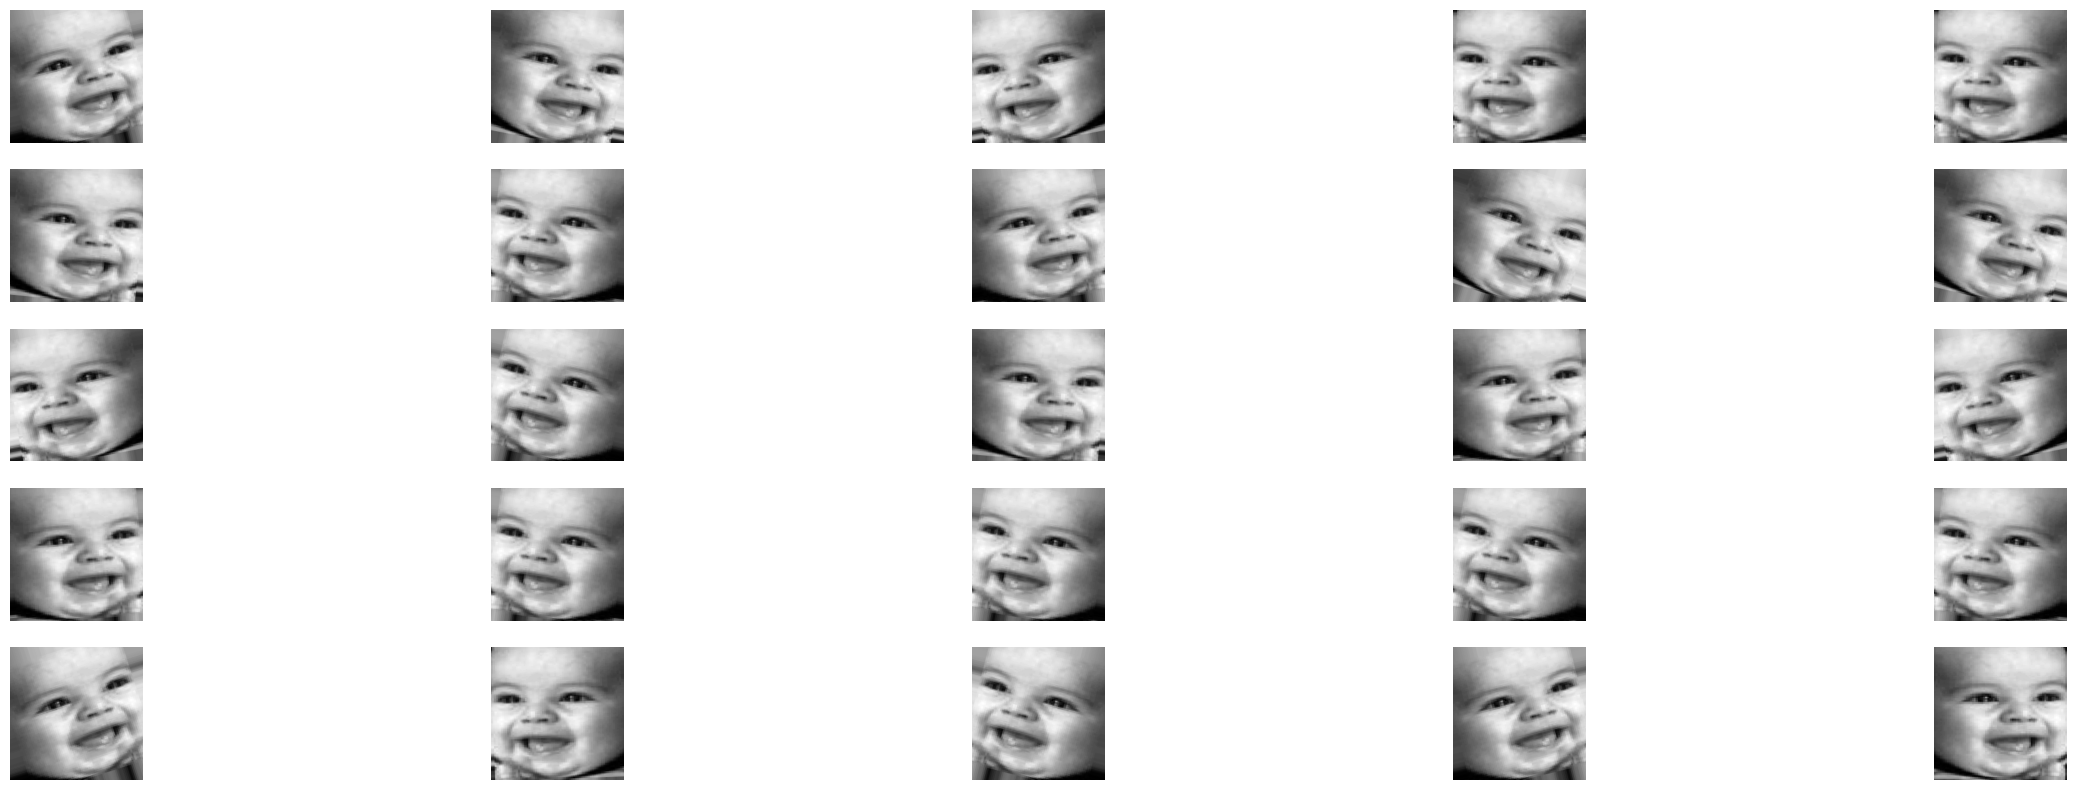

In [8]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(30, 10))
    image = images[0]    
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0].numpy() / 255, cmap='gray')
        plt.axis('off')
plt.show()

In [9]:
# MODEL
INPUT_SHAPE = image.shape
#print('INPUT SHAPE: ',  INPUT_SHAPE)
base_model = tf.keras.Sequential()

base_model.add(layers.Input(shape=INPUT_SHAPE))

base_model.add(layers.Conv2D(filters=15, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV01'))
base_model.add(layers.BatchNormalization(name='BNOR01'))
base_model.add(layers.Activation('relu', name='RELU01'))
base_model.add(layers.Dropout(0.1, name='DROP01'))

base_model.add(layers.MaxPool2D(pool_size=(4,4), name='MP0102'))

base_model.add(layers.Conv2D(filters=30, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV02'))
base_model.add(layers.BatchNormalization(name='BNOR02'))
base_model.add(layers.Activation('relu', name='RELU02'))
base_model.add(layers.Dropout(0.1, name='DROP02'))

base_model.add(layers.MaxPool2D(pool_size=(4,4), name='MP0203'))

base_model.add(layers.Conv2D(filters=60, kernel_size=3, padding='same', kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4), name='CONV03'))
base_model.add(layers.BatchNormalization(name='BNOR03'))
base_model.add(layers.Activation('relu', name='RELU03'))
base_model.add(layers.Dropout(0.1, name='DROP03'))

base_model.add(layers.Flatten(name='FLAT01'))

base_model.add(layers.Dense(8, name='DENS01'))
base_model.add(layers.Dropout(0.1, name='DROP05'))

base_model.add(layers.Activation('softmax', name='SOFT01'))

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV01 (Conv2D)             (None, 224, 224, 15)      150       
                                                                 
 BNOR01 (BatchNormalization)  (None, 224, 224, 15)     60        
                                                                 
 RELU01 (Activation)         (None, 224, 224, 15)      0         
                                                                 
 DROP01 (Dropout)            (None, 224, 224, 15)      0         
                                                                 
 MP0102 (MaxPooling2D)       (None, 56, 56, 15)        0         
                                                                 
 CONV02 (Conv2D)             (None, 56, 56, 30)        4080      
                                                                 
 BNOR02 (BatchNormalization)  (None, 56, 56, 30)      

In [10]:
inputs = layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
outputs = base_model(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 sequential_1 (Sequential)   (None, 8)                 114998    
                                                                 
Total params: 114,998
Trainable params: 114,788
Non-trainable params: 210
_________________________________________________________________


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

2022-11-17 09:14:22.758300: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-11-17 09:14:23.850972: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


(16, 8)


In [13]:
print('CNN output format')
print(' '.join('{:^12s}'.format(el) for el in class_names))
for row in feature_batch.numpy():
   print(' '.join('{:^12.2f}'.format(el) for el in row))

CNN output format
   anger       contempt     disgust        fear      happiness    neutrality    sadness      surprise  
    0.24         0.00         0.66         0.00         0.00         0.00         0.10         0.00    
    0.00         0.00         1.00         0.00         0.00         0.00         0.00         0.00    
    0.02         0.00         0.98         0.00         0.00         0.00         0.00         0.00    
    0.00         0.00         0.98         0.00         0.00         0.00         0.02         0.00    
    0.00         0.00         1.00         0.00         0.00         0.00         0.00         0.00    
    0.00         0.00         0.99         0.00         0.00         0.00         0.01         0.00    
    0.00         0.00         1.00         0.00         0.00         0.00         0.00         0.00    
    0.00         0.00         0.08         0.00         0.00         0.00         0.92         0.00    
    0.00         0.00         0.78         0.0

In [14]:
print('Dataset label format')
label_batch.numpy()

Dataset label format


array([1, 0, 4, 2, 5, 4, 6, 1, 3, 4, 6, 6, 0, 4, 6, 4], dtype=int32)

In [15]:
METRICS = [
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

In [16]:
# Compile the model
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [17]:
# Train the model
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

69/69 [==============================] - 2s 22ms/step - loss: 20.7221 - accuracy: 0.0785
initial loss: 20.72
initial accuracy: 0.08


In [18]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=10*BATCH_SIZE,
                                                 verbose=1)

initial_epochs = 200
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=initial_epochs,
                    callbacks=[cp_callback]
                    )

Epoch 1/200
159/275 [================>.............] - ETA: 8s - loss: 2.2845 - accuracy: 0.1741
Epoch 1: saving model to training_1/cp.ckpt
275/275 [==============================] - 22s 77ms/step - loss: 2.2247 - accuracy: 0.1843 - val_loss: 1.9827 - val_accuracy: 0.2308
Epoch 2/200
 44/275 [===>..........................] - ETA: 16s - loss: 2.0758 - accuracy: 0.2386
Epoch 2: saving model to training_1/cp.ckpt
204/275 [=====================>........] - ETA: 5s - loss: 2.0679 - accuracy: 0.2350
Epoch 2: saving model to training_1/cp.ckpt
275/275 [==============================] - 21s 76ms/step - loss: 2.0624 - accuracy: 0.2365 - val_loss: 1.9051 - val_accuracy: 0.2856
Epoch 3/200
 89/275 [========>.....................] - ETA: 13s - loss: 1.9933 - accuracy: 0.2605
Epoch 3: saving model to training_1/cp.ckpt
249/275 [==========================>...] - ETA: 1s - loss: 2.0023 - accuracy: 0.2497
Epoch 3: saving model to training_1/cp.ckpt
275/275 [==============================] - 23s 83ms

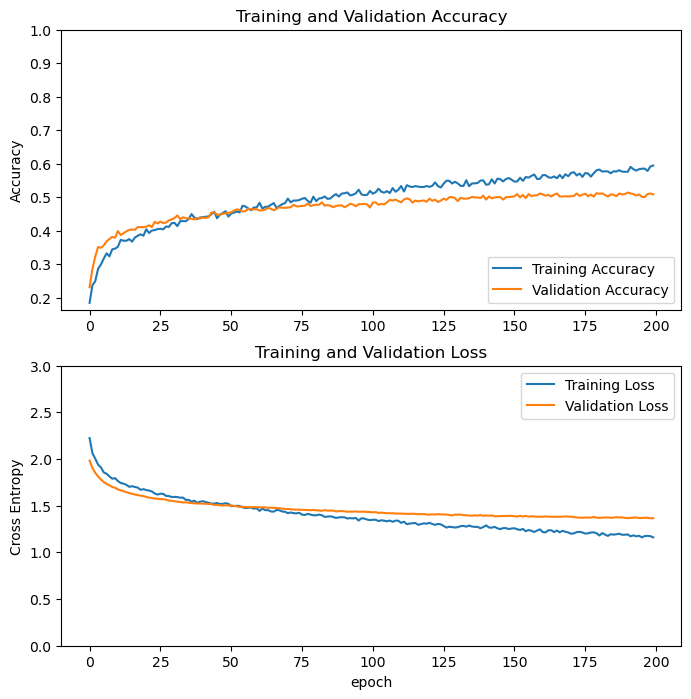

In [19]:
# Show the learning curves of the training and validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
Labels = []
Predss = []
count = 0
for batch, labels in validation_dataset:
    logits = model.predict_on_batch(batch)
    preds  = np.argmax(logits, axis=1) 
    Predss += preds.tolist()
    Labels += labels.numpy().tolist()
    count  += 1

In [21]:
print('Confusion matrix')
confusion = confusion_matrix(Labels, Predss)
print(' '.join('{:<12s}'.format(el) for el in class_names))
for row in confusion:
    print(' '.join('{:<12d}'.format(el) for el in row))
print('===')
print('Precision per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=0)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean precision: {:<12.2f}'.format(np.mean(num/den)))
print('===')
print('Recall per class')
num = [confusion[i,i] for i in range(len(confusion))]
den = np.sum(confusion, axis=1)
print(' '.join('{:<12s}'.format(el) for el in class_names))
print(' '.join('{:<12.2f}'.format(el) for el in num/den))
print('---')
print('mean recall (balanced accuracy score): {:<12.2f}'.format(np.mean(num/den)))

Confusion matrix
anger        contempt     disgust      fear         happiness    neutrality   sadness      surprise    
69           2            17           7            29           19           16           5           
5            4            3            0            5            7            1            0           
22           0            20           6            21           3            6            5           
16           0            3            37           15           5            10           44          
10           2            8            2            230          9            4            15          
10           2            6            5            8            47           20           5           
21           3            13           11           29           26           38           6           
6            1            0            19           22           3            1            112         
===
Precision per class
anger        contempt  

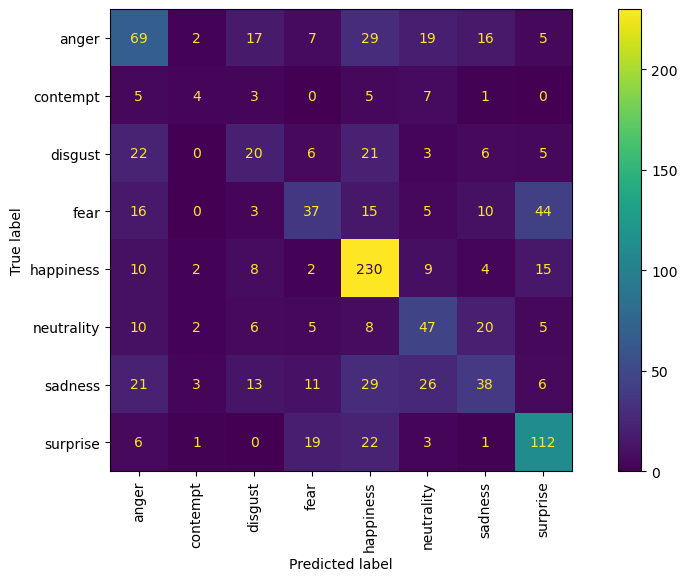

In [22]:
fig, ax = plt.subplots(figsize=(20*0.6, 10*0.6))
ConfusionMatrixDisplay.from_predictions(Labels, Predss, normalize=None, display_labels=class_names, xticks_rotation='vertical', values_format='d', ax=ax)

13/13 [==============================] - 0s 18ms/step - loss: 1.4550 - accuracy: 0.4567
Test accuracy : 0.45673078298568726
pred [[1.3083191e-01 2.5738440e-02 9.9864557e-02 2.5698047e-02 2.3372589e-01
  3.8756144e-01 1.7124377e-02 7.9455338e-02]
 [1.1638533e-01 3.2606270e-02 2.2616436e-01 5.8367968e-02 9.1460198e-02
  8.6545877e-02 3.6444318e-01 2.4026848e-02]
 [1.6711980e-02 5.0630122e-05 9.3938160e-04 3.3468734e-02 2.7482357e-04
  2.9932644e-04 6.8231579e-04 9.4757277e-01]
 [1.5891731e-01 2.5345387e-02 1.8594229e-01 3.4378935e-02 3.1204227e-01
  6.3020788e-02 1.5094858e-02 2.0525813e-01]
 [3.7657502e-01 3.0274712e-03 6.8640858e-02 1.2432610e-01 9.0551510e-02
  8.9127375e-03 8.7262496e-02 2.4070381e-01]
 [2.0854911e-01 9.4876468e-02 1.5829313e-01 7.8772731e-02 2.6138853e-02
  2.6801768e-01 6.1177466e-02 1.0417459e-01]
 [3.8680729e-01 9.5383897e-02 1.7613709e-01 4.9653139e-02 8.3143087e-03
  1.0071793e-01 1.3780762e-01 4.5178663e-02]
 [4.8806984e-03 1.1111718e-04 6.9957161e-03 9.267178

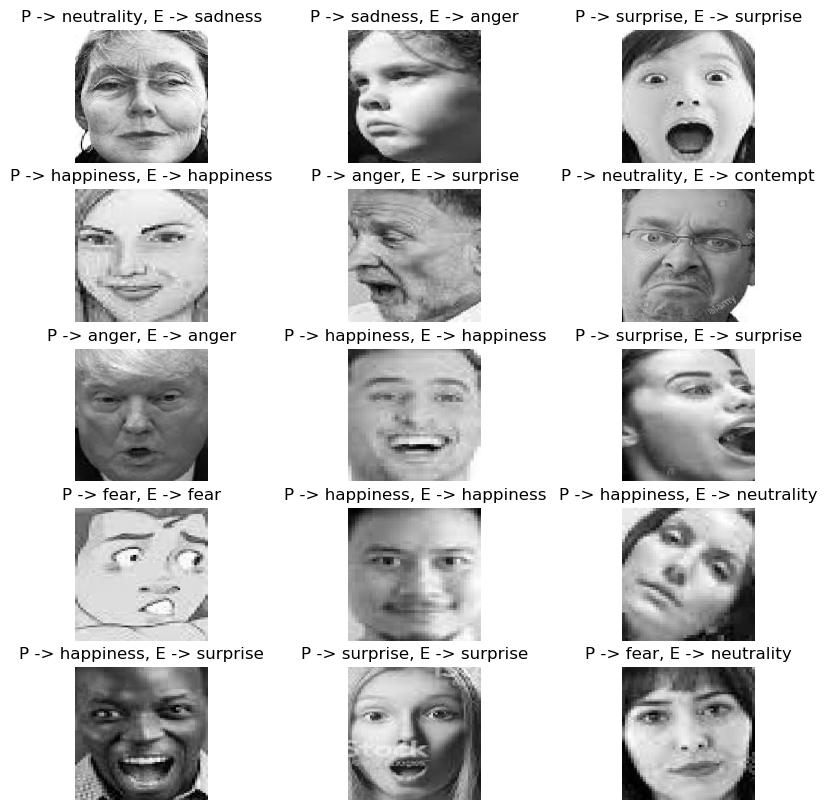

In [23]:
# Evaluation and prediction
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print('pred', predictions)


# Apply a sigmoid since our model returns logits
predicted_class = np.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class)
print('Labels:\n', label_batch)
print('Classes:\n', class_names)
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"), cmap='gray')
    plt.title('P -> {}, E -> {}'.format(class_names[predicted_class[i]], class_names[label_batch[i]]))
    plt.axis("off")